## Allowing import from parent's directory

In [1]:
import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

## Importing the required modules

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import time
import tools.loaddata as loaddata
import tools.dataassimilation as da

import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

## Summary of findings

We expect that increasing the variance would reduce MSE for PCA compression. However, in this notebook we aim to test the increase of variance value against the MSE for PCA compression with data assimilation.

At the end of this notebook, we have confirmed the fact that our hypothesis is true and that for the lowest MSE we should use the highest possible variance

## Loading and reshaping data

In [6]:
path_train = "../data/train/"
path_test = "../data/test/"
path_back = "../data/background/"
path_obs = "../data/satellite/"

In [7]:
train_full, test, model_data, satellite_data = loaddata.load_all_data(path_train, path_test, path_back, path_obs)

In [8]:
train = train_full[0:300]

In [9]:
print(f"Train data before reshaping: {np.shape(train)}")
print(f"Test data before reshaping: {np.shape(test)}")
print(f"background data before reshaping: {np.shape(model_data)}")
print(f"observational data before reshaping: {np.shape(satellite_data)}")

Train data before reshaping: (300, 871, 913)
Test data before reshaping: (300, 871, 913)
background data before reshaping: (5, 871, 913)
observational data before reshaping: (5, 871, 913)


In [10]:
train_1D, test_1D, model_data_1D, satellite_data_1D = loaddata.reshape_all_datasets(train, test, model_data, satellite_data)

In [11]:
print(f"Train data after reshaping: {train_1D.shape}")
print(f"Test data after reshaping: {test_1D.shape}")
print(f"Model data after reshaping: {model_data_1D.shape}")
print(f"Observational data after reshaping: {satellite_data_1D.shape}")

Train data after reshaping: (300, 795223)
Test data after reshaping: (300, 795223)
Model data after reshaping: (5, 795223)
Observational data after reshaping: (5, 795223)


## Iterating through p values, and print out the MSE

In [12]:
pca = PCA(min(train_1D.shape))
pca.fit(train_1D)

PCA(n_components=300)

In [13]:
p_list = [0.85, 0.87, 0.90, 0.95, 0.99]
k_list = []
mse_physical_before = []
mse_physical_after = []
mse_latent_before = []
mse_latent_after = []

for p in p_list:
    start = time.time()
    ## Choosing PCA components
    cumsum_eig = np.cumsum(pca.explained_variance_ratio_)
    k = np.argmax(cumsum_eig >= p) + 1 # k is the number of principal components we have chosen
    k_list.append(k)

    ## Performing PCA
    pca_compress = PCA(n_components=k)
    pca_compress.fit(train_1D)

    ## Compressing the data
    model_data_compr = pca_compress.transform(model_data_1D)
    satellite_data_compr = pca_compress.transform(satellite_data_1D)
    
    # Data Assimilation - Kalman Filter (BLUE)
    latent_space = k
    nNodes = latent_space  # latent_space is the size of the compressed variables or number of principal components used
    I = np.identity(nNodes)
    R = np.cov(satellite_data_compr.T)
    H = I 
    B = 0.001 * I

    ## Performing data assimilation
    updated_data_array = da.assimilate(B, H, R, model_data_compr, satellite_data_compr)

    ## Calculating MSE in latent space
    mse_before_DA = da.mse(satellite_data_compr, model_data_compr)
    mse_after_DA = da.mse(satellite_data_compr, updated_data_array)
    mse_latent_before.append(mse_before_DA)
    mse_latent_after.append(mse_after_DA)
    
    ## Calculating MSE in physical space
    updated_data_recon = pca_compress.inverse_transform(updated_data_array)
    mse_before_DA_physical = da.mse(satellite_data_1D, model_data_1D)
    mse_after_DA_physical = da.mse(satellite_data_1D, updated_data_recon)
    mse_physical_before.append(mse_before_DA_physical)
    mse_physical_after.append(mse_after_DA_physical)

    print("k:", k, "p: ", p, "\n","mse_l_bef: ", mse_before_DA, "mse_l_af: ",mse_after_DA,"\n", "mse_p_bef: ", mse_before_DA_physical, "mse_p_af: ", mse_after_DA_physical)
    time_train = time.time() - start
    print('Execution time: ', time_train)

k: 23 p:  0.85 
 mse_l_bef:  1345.640198772879 mse_l_af:  441.0562979721959 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.07559164529767719
Execution time:  24.004759073257446
k: 32 p:  0.87 
 mse_l_bef:  980.3857317729131 mse_l_af:  299.03441839298455 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.0746527365232419
Execution time:  18.033245086669922
k: 48 p:  0.9 
 mse_l_bef:  661.8940037186052 mse_l_af:  184.73316845200026 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.07329859240050886
Execution time:  19.762857913970947
k: 84 p:  0.95 
 mse_l_bef:  396.0574499852082 mse_l_af:  73.47879421838019 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.0687597465136334
Execution time:  33.05784893035889
k: 195 p:  0.99 
 mse_l_bef:  187.390448543866 mse_l_af:  25.565146105423008 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.06400222630206125
Execution time:  70.9097728729248


## Visualizing the results

We can see that as the p values increase, the physical mse after data assimilation decreases. This coincides with the latent space (also note how the gap between MSE decrease over higher p). Hence, we expect good result with a large p

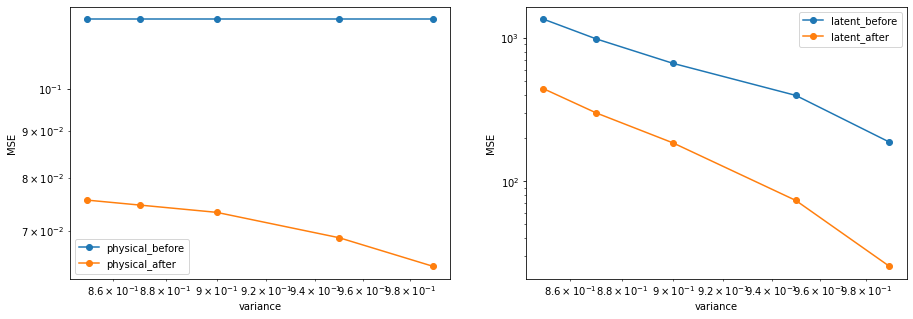

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.loglog(p_list, mse_physical_before, '-o', label="physical_before")
ax1.loglog(p_list, mse_physical_after, '-o', label="physical_after")
ax1.set_xlabel("variance")
ax1.set_ylabel("MSE")
ax1.legend()
ax2.loglog(p_list, mse_latent_before, '-o', label="latent_before")
ax2.loglog(p_list, mse_latent_after, '-o', label="latent_after")
ax2.set_xlabel("variance")
ax2.set_ylabel("MSE")
ax2.legend()

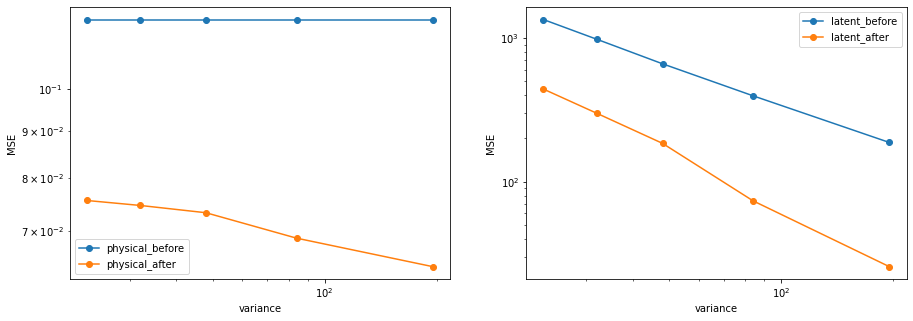

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.loglog(k_list, mse_physical_before, '-o', label="physical_before")
ax1.loglog(k_list, mse_physical_after, '-o', label="physical_after")
ax1.set_xlabel("variance")
ax1.set_ylabel("MSE")
ax1.legend()
ax2.loglog(k_list, mse_latent_before, '-o', label="latent_before")
ax2.loglog(k_list, mse_latent_after, '-o', label="latent_after")
ax2.set_xlabel("variance")
ax2.set_ylabel("MSE")
ax2.legend()